In [1]:
import pandas as pd
import re
import io
from unicodedata import normalize
from sqlalchemy import create_engine
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import pandas_profiling

%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
host = 'ssf.csqdzeslttvs.us-east-1.rds.amazonaws.com'
port = 5432
user = 'postgres'
password = 'BRfM)p4JT?JecpZz'
database = 'postgres'

In [3]:
connDB = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}', encoding = 'utf-8')
conn = connDB.raw_connection()
cur = conn.cursor()

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
dfgoldenrecord = pd.read_sql('select b.id, b.genero , b.edad, b.rangoedad ,  b.categoria_afiliado , b.ubicacion_residencia ,b.grupo_etnico , b.caracteristica_poblacion , b.fctor_vulnerabilidad , b.conflicto, b.desplazamiento, b.discapacidad, a.fecha_reporte , a.fecha_perdida_empleo , cj.caja_name , mn.municipio , mn.departamento , mn.region , a.fecha_radicacion , a.fecha_aprobacion, a.numero_dias_aprobacion ,   a.fecha_liquidacion_beneficio , a.fecha_liquidacion_beneficio , a.fecha_suspension_beneficio , a.fecha_reactivacion_beneficio, a.numero_beneficios_liquidados, a.beneficio_aprobado  FROM dwh."5-312A_CIRCULAR_COVID" as a left outer join dwh.d_beneficiario as b on a.beneficiarioid = b.beneficiarioid left outer join dwh.d_caja_compensacion cj on cj.cajaid  = a.cajaid left outer join dwh.d_municipio mn on mn.municipioid = a.municipioid where a.fecha_radicacion > 20200327', connDB )

In [5]:
dfgoldenrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460377 entries, 0 to 460376
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            460377 non-null  object 
 1   genero                        460377 non-null  object 
 2   edad                          460377 non-null  int64  
 3   rangoedad                     460377 non-null  int64  
 4   categoria_afiliado            460377 non-null  object 
 5   ubicacion_residencia          460377 non-null  object 
 6   grupo_etnico                  460377 non-null  object 
 7   caracteristica_poblacion      460377 non-null  object 
 8   fctor_vulnerabilidad          460377 non-null  object 
 9   conflicto                     460377 non-null  int64  
 10  desplazamiento                460377 non-null  int64  
 11  discapacidad                  460377 non-null  int64  
 12  fecha_reporte                 460377 non-nul

In [6]:
dfgoldenrecord["beneficio_aprobado"] = dfgoldenrecord["beneficio_aprobado"].astype(int)

In [7]:
model1 = pd.DataFrame(dfgoldenrecord[['genero','rangoedad','categoria_afiliado', 'grupo_etnico','ubicacion_residencia','conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo','caja_name', 'region','beneficio_aprobado']])

In [8]:
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['categoria_afiliado'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['grupo_etnico'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['ubicacion_residencia'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['region'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['caja_name'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['genero'], drop_first=True)) #Use drop_first to drop the first category

In [9]:
model1.columns = [c.replace(' ', '_') for c in model1.columns]
model1.rename(columns={'region_Región_Eje_Cafetero_-_Antioquia':'region_Región_Eje_Cafetero_Antioquia'}, inplace=True)

In [10]:

model1.drop('fecha_perdida_empleo', axis=1, inplace=True)

In [11]:
model1
#.sample(200000)

rangoedad  conflicto  ...  genero_INDETERMINADO  genero_MUJER
0               4          0  ...                     0             0
1               5          0  ...                     0             0
2               4          0  ...                     0             0
3               6          0  ...                     0             0
4               4          0  ...                     0             0
...           ...        ...  ...                   ...           ...
460372          5          0  ...                     0             0
460373          5          0  ...                     0             1
460374          4          0  ...                     0             1
460375          4          0  ...                     0             1
460376          5          0  ...                     0             1

[460377 rows x 65 columns]

In [12]:
# Setting target variable
y = model1['beneficio_aprobado']
# Making feature data set by removing target variable  from it
x = model1.drop(['beneficio_aprobado'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [13]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = tf.keras.models.Sequential()
# First our input layer. For this layer, and this layer only, we need to specify the size of our input. For our dataset this means the amount of columns in our X.
model.add(tf.keras.layers.Flatten(input_shape=(x.shape[1],)))
# Now some hidden layers
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
# Finally, our output layer. we use only 1 and with sigmoid activation
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
#we use a binary crossentropy becaouse our classes are 1 and 0
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,329
Trainable params: 1,329
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_train, y_train, validation_split=0.20, epochs=10, batch_size=100)
#, callbacks=[callback]

Epoch 1/10
2579/2579 [==============================] - 4s 2ms/step - loss: 0.5568 - accuracy: 0.6822 - val_loss: 0.5455 - val_accuracy: 0.6895
Epoch 2/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5444 - accuracy: 0.6910 - val_loss: 0.5455 - val_accuracy: 0.6908
Epoch 3/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5431 - accuracy: 0.6920 - val_loss: 0.5434 - val_accuracy: 0.6905
Epoch 4/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5423 - accuracy: 0.6923 - val_loss: 0.5432 - val_accuracy: 0.6895
Epoch 5/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5419 - accuracy: 0.6929 - val_loss: 0.5429 - val_accuracy: 0.6915
Epoch 6/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5414 - accuracy: 0.6929 - val_loss: 0.5424 - val_accuracy: 0.6919
Epoch 7/10
2579/2579 [==============================] - 4s 1ms/step - loss: 0.5412 - accuracy: 0.6935 - val_loss: 0.5431 - val_accuracy:

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

4317/4317 [==============================] - 4s 881us/step - loss: 0.5409 - accuracy: 0.6937
Test accuracy: 0.693673312664032


In [17]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model2 = tf.keras.models.Sequential()
# First our input layer. For this layer, and this layer only, we need to specify the size of our input. For our dataset this means the amount of columns in our X.
model2.add(tf.keras.layers.Flatten(input_shape=(x.shape[1],)))
# Now some hidden layers
model2.add(tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation=tf.nn.relu))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation=tf.nn.relu))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation=tf.nn.relu))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation=tf.nn.relu))
# Finally, our output layer. we use only 1 and with sigmoid activation
model2.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
#we use a binary crossentropy becaouse our classes are 1 and 0
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

In [19]:
model2.fit(x_train, y_train, validation_split=0.20, epochs=10, batch_size=100)

Epoch 1/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5668 - accuracy: 0.6833 - val_loss: 0.5529 - val_accuracy: 0.6912
Epoch 2/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5533 - accuracy: 0.6899 - val_loss: 0.5530 - val_accuracy: 0.6907
Epoch 3/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5506 - accuracy: 0.6900 - val_loss: 0.5487 - val_accuracy: 0.6920
Epoch 4/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5494 - accuracy: 0.6915 - val_loss: 0.5487 - val_accuracy: 0.6891
Epoch 5/10
2579/2579 [==============================] - 6s 3ms/step - loss: 0.5493 - accuracy: 0.6915 - val_loss: 0.5474 - val_accuracy: 0.6905
Epoch 6/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5484 - accuracy: 0.6911 - val_loss: 0.5463 - val_accuracy: 0.6894
Epoch 7/10
2579/2579 [==============================] - 6s 2ms/step - loss: 0.5487 - accuracy: 0.6911 - val_loss: 0.5471 - val_accuracy:

In [20]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

4317/4317 [==============================] - 4s 956us/step - loss: 0.5456 - accuracy: 0.6935
Test accuracy: 0.693543016910553


In [21]:
x_test.columns

Index(['rangoedad', 'conflicto', 'desplazamiento', 'discapacidad',
       'categoria_afiliado_B', 'categoria_afiliado_C', 'categoria_afiliado_D',
       'grupo_etnico_COMUNIDAD_NEGRA', 'grupo_etnico_COMUNIDAD_RAIZAL',
       'grupo_etnico_INDÃ�GENA', 'grupo_etnico_NINGUNO_DE_LOS_ANTERIORES',
       'grupo_etnico_NO_DISPONIBLE', 'grupo_etnico_PALANQUERO',
       'grupo_etnico_ROOM/GITANO', 'ubicacion_residencia_URBANA',
       'region_Región_Centro_Oriente', 'region_Región_Centro_Sur',
       'region_Región_Eje_Cafetero_Antioquia', 'region_Región_Llano',
       'region_Región_Pacífico', 'caja_name_CAFAM', 'caja_name_CAFAMAZ',
       'caja_name_CAFASUR', 'caja_name_CAJACOPI_Barranquilla',
       'caja_name_CAJAMAG', 'caja_name_CAJASAI', 'caja_name_CAJASAN',
       'caja_name_COFREM', 'caja_name_COLSUBSIDIO',
       'caja_name_COMBARRANQUILLA', 'caja_name_COMCAJA', 'caja_name_COMFABOY',
       'caja_name_COMFACA_Comfamiliar_Caqueta', 'caja_name_COMFACASANARE',
       'caja_name_COMFACAUCA

In [106]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model3 = tf.keras.models.Sequential()
# First our input layer. For this layer, and this layer only, we need to specify the size of our input. For our dataset this means the amount of columns in our X.
model3.add(tf.keras.layers.Flatten(input_shape=(x.shape[1],)))
# Now some hidden layers
model3.add(tf.keras.layers.Dense(65, activation=tf.nn.relu))
model3.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
# Finally, our output layer. we use only 1 and with sigmoid activation
model3.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
#we use a binary crossentropy becaouse our classes are 1 and 0
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [107]:
model3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 65)                4225      
_________________________________________________________________
dense_64 (Dense)             (None, 7046)              465036    
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 7047      
Total params: 476,308
Trainable params: 476,308
Non-trainable params: 0
_________________________________________________________________


In [111]:
model3.fit(x_train, y_train, validation_split=0.20, epochs=20, batch_size=25000)

Epoch 1/20
11/11 [==============================] - 26s 2s/step - loss: 0.5577 - accuracy: 0.6894 - val_loss: 0.5621 - val_accuracy: 0.6827
Epoch 2/20
11/11 [==============================] - 24s 2s/step - loss: 0.5562 - accuracy: 0.6901 - val_loss: 0.5573 - val_accuracy: 0.6846
Epoch 3/20


KeyboardInterrupt: ignored

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model3.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
1080/1080 [==============================] - 1s 1ms/step - loss: 0.5406 - accuracy: 0.6954
test loss, test acc: [0.5405949354171753, 0.6953820586204529]


In [26]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model3.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (3, 1)


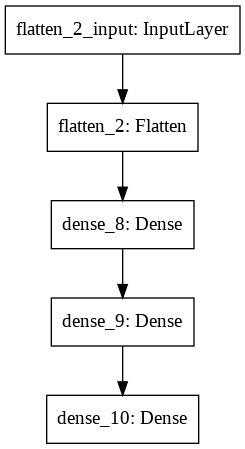

In [27]:
tf.keras.utils.plot_model(
    model3, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [30]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model3.save('saved_model/Modelo_NN_aprobacion') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/Modelo_NN_aprobacion/assets


**Modelo 2 numeros de dias de aprobacion**


In [37]:
dfgoldenrecord.columns
dfgoldenrecord_nda = dfgoldenrecord[dfgoldenrecord['numero_dias_aprobacion']>0]
dfgoldenrecord_nda.shape

(236023, 27)

In [38]:
model2 = pd.DataFrame(dfgoldenrecord_nda[['genero',  'rangoedad', 'categoria_afiliado', 'ubicacion_residencia', 'grupo_etnico', 'conflicto', 'desplazamiento', 'discapacidad','caja_name', 'region', 'numero_dias_aprobacion']])

In [39]:
#one hot encoding
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['categoria_afiliado'], drop_first=True)) #Use drop_first to drop the first category
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['ubicacion_residencia'], drop_first=True)) #Use drop_first to drop the first category
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['region'], drop_first=True)) #Use drop_first to drop the first category
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['caja_name'], drop_first=True)) #Use drop_first to drop the first category
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['genero'], drop_first=True)) #Use drop_first to drop the first category
model2 = pd.DataFrame(pd.get_dummies(model2,columns=['grupo_etnico'], drop_first=True)) #Use drop_first to drop the first category

In [40]:
#sample 100000 observations from DF
sample2 = model2
#.sample(100000)
#.sample(10000)
sample2.shape

(236023, 65)

In [41]:
sample2.head()

rangoedad  conflicto  ...  grupo_etnico_PALANQUERO  grupo_etnico_ROOM/GITANO
0          4          0  ...                        0                         0
1          5          0  ...                        0                         0
2          4          0  ...                        0                         0
3          6          0  ...                        0                         0
4          4          0  ...                        0                         0

[5 rows x 65 columns]

In [99]:
    # Setting target variable
y2 = sample2['numero_dias_aprobacion']
    
# Making feature data set by removing target variable  from it
   
x2 = sample2.drop(['numero_dias_aprobacion'], axis=1)
  

    # Making training and testing data sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state=42)


In [147]:

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model4 = tf.keras.models.Sequential()
# First our input layer. For this layer, and this layer only, we need to specify the size of our input. For our dataset this means the amount of columns in our X.
#model4.add(tf.keras.layers.Flatten(input_shape=(x2.shape[1],)))
# Now some hidden layers
#model4.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))

model4.add(Dense(65, input_dim=64, activation='relu', kernel_initializer='normal'))
model4.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model4.add(Dense(1, activation='linear'))
# Finally, our output layer. we use only 1 and with sigmoid activation
#model4.add(tf.keras.layers.Dense(1, activation='linear'))

#we use a binary crossentropy becaouse our classes are 1 and 0
model4.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mse'])


In [148]:
model4.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 65)                4225      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                4224      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 65        
Total params: 8,514
Trainable params: 8,514
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.fit(x_train2, y_train2, validation_split=0.30, epochs=1000, batch_size=10000)

Epoch 1/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.5411 - mse: 796.4286 - val_loss: 0.5433 - val_mse: 807.7866
Epoch 2/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.5411 - mse: 795.6362 - val_loss: 0.5434 - val_mse: 811.4382
Epoch 3/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.5410 - mse: 794.0244 - val_loss: 0.5434 - val_mse: 811.0265
Epoch 4/1000
12/12 [==============================] - 0s 29ms/step - loss: 0.5409 - mse: 796.1200 - val_loss: 0.5430 - val_mse: 807.1460
Epoch 5/1000
12/12 [==============================] - 0s 29ms/step - loss: 0.5407 - mse: 796.0314 - val_loss: 0.5429 - val_mse: 806.8870
Epoch 6/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.5406 - mse: 795.2721 - val_loss: 0.5429 - val_mse: 807.6384
Epoch 7/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.5405 - mse: 794.8590 - val_loss: 0.5427 - val_mse: 806.7546
Epoch 8/1000
12/12 [=====================